## FRE 7773 Machine Learning in Financial Engineering

## Final Project

### Yuyang Zhao | Tianjing Cao

#### Created: Nov 26, 2021

#### Last Modified: Nov 26, 2021

The purpose of this project is to use different strategies to determine buy/sell order. The backtester helps us to decide whether it is worth live-trading a set of strategy rules. It provides us with an idea of how a strategy might have performed in the past. We will analyze the PNL, sharpe ratio, and decay of each of the strategies and compare the results.

First, import all the libraries needed.

In [1]:
import math
import os
import random
import re
import sys
import numpy
import pandas
import datetime
from abc import ABC
from collections import deque


from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn import tree
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

from matplotlib import colors
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sn

Now, setup constructors for direction and base_strategy

In [2]:
class DIRECTION:
    BUY=1
    SELL=-1
    HOLD = 0

class base_strategy(ABC):
    def predict(self):
        pass
    def fit(self,price):
        pass

Here are the three strategies we are going to use (Logistic Regression, Support Vector Machine, and Random Forest). We always fit the model at the 500th day and use the remaining data to predict. Moreover, we always start by buying.

In [3]:
#Logistic Regression
class strategy1(base_strategy):
    
    def __init__(self):
        super().__init__()
        self.num_days = 0
        self.previous_day_price = None
        self.logistic_regressand_y = []
        self.logistic_regressors_X = []
        self.regression_results = None
        self.buy = True
    
    def predict(self, price_update):
        if self.regression_results is not None:
            regressors = [[
                price_update['price'],
                price_update['open'] - price_update['close'],
                price_update['high'] - price_update['low'],
                price_update['SP500']
            ]]
            
            prediction = self.regression_results.predict(regressors)[0]
            
            if prediction == 1 :
            #and self.buy:
            #    self.buy = False
                return DIRECTION.BUY
            
            if prediction == -1 :
            #and not self.buy:
            #    self.buy = True
                return DIRECTION.SELL
            
        return DIRECTION.HOLD
    
    def fit(self, price_update):
        self.num_days += 1
        
        if self.previous_day_price is None or \
            price_update['price'] > self.previous_day_price:
            self.logistic_regressand_y.append(1)
        else:
            self.logistic_regressand_y.append(-1)
            
        self.previous_day_price = price_update['price']
        
        self.logistic_regressors_X.append([
            price_update['price'],
            price_update['open'] - price_update['close'],
            price_update['high'] - price_update['low'],
            price_update['SP500']
        ])
        
        if self.num_days >= 500:
            self.regression_results = LogisticRegression().fit(self.logistic_regressors_X,
                                                               self.logistic_regressand_y)
            
            

In [4]:
#Suppoer Vector Machine
class strategy2(base_strategy):
    def __init__(self):
        super().__init__()
        self.num_days = 0
        self.previous_day_price = None
        self.svc_y = []
        self.svc_X = []
        self.svc_results = None
        self.buy = True
    
    def predict(self, price_update):
        if self.svc_results is not None:
            classifier = [[
                price_update['price'],
                price_update['open'] - price_update['close'],
                price_update['high'] - price_update['low'],
                price_update['SP500']
            ]]
            
            prediction = self.svc_results.predict(classifier)[0]
            
            if prediction == 1 : #and self.buy:
            #    self.buy = False
                return DIRECTION.BUY
            
            if prediction == -1: #and not self.buy:
            #    self.buy = True
                return DIRECTION.SELL
            
        return DIRECTION.HOLD
    
    def fit(self, price_update):
        self.num_days += 1
        
        if self.previous_day_price is None or \
            price_update['price'] > self.previous_day_price:
            self.svc_y.append(1)
        else:
            self.svc_y.append(-1)
            
        self.previous_day_price = price_update['price']
        
        self.svc_X.append([
            price_update['price'],
            price_update['open'] - price_update['close'],
            price_update['high'] - price_update['low'],
            price_update['SP500']
        ])
        
        #do a cross validation to determine the best set of parameters if more time
        if self.num_days >= 500:
            self.svc_results = svm.SVC(kernel = 'rbf', C = 5, gamma = 0.001).fit(self.svc_X, self.svc_y)


In [5]:
#Random Forest
class strategy3(base_strategy):
    
    def __init__(self):
        super().__init__()
        self.num_days = 0
        self.previous_day_price = None
        self.random_forest_y = []
        self.random_forest_X = []
        self.random_forest_results = None
        self.buy = True
    
    def predict(self, price_update):
        if self.random_forest_results is not None:
            regressors = [[
                price_update['price'],
                price_update['open'] - price_update['close'],
                price_update['high'] - price_update['low'],
                price_update['SP500']
            ]]
            
            prediction = self.random_forest_results.predict(regressors)[0]
            
            if prediction == 1:# and self.buy:
           #     self.buy = False
                return DIRECTION.BUY
            
            if prediction == -1: # and not self.buy:
           #     self.buy = True
                return DIRECTION.SELL
            
        return DIRECTION.HOLD
    
    def fit(self, price_update):
        self.num_days += 1
        
        if self.previous_day_price is None or \
            price_update['price'] > self.previous_day_price:
            self.random_forest_y.append(1)
        else:
            self.random_forest_y.append(-1)
            
        self.previous_day_price = price_update['price']
        
        self.random_forest_X.append([
            price_update['price'],
            price_update['open'] - price_update['close'],
            price_update['high'] - price_update['low'],
            price_update['SP500']
        ])
        
        if self.num_days == 500:
            #model_RF=RandomForestClassifier(n_estimators=100,max_features=3)
            #kfold=model_selection.KFold(n_splits=10)
            #self.random_forest_results = model_selection.cross_val_score(model_bagging,x,y,cv=kfold)
            param_test1 = {'n_estimators':range(10,71,10),
                           'min_samples_split':range(80,150,20),
                           'min_samples_leaf':range(10,60,10)}
            gsearch1 = GridSearchCV(estimator = RandomForestClassifier(max_depth=8,                                                                    
                                                                       random_state=10), 
                                    param_grid = param_test1,
                                    scoring='roc_auc',
                                    cv=5)
            
            gsearch1.fit(self.random_forest_X,self.random_forest_y)
            n_estimators_=gsearch1.best_params_["n_estimators"]
            min_samples_split_=gsearch1.best_params_["min_samples_split"]
            min_samples_leaf_=gsearch1.best_params_["min_samples_leaf"]
            self.random_forest_results=RandomForestClassifier(n_estimators=n_estimators_,
                                                              min_samples_split=min_samples_split_,
                                                              min_samples_leaf=min_samples_leaf_).fit(self.random_forest_X, self.random_forest_y)


the cross validation method resamples the dataset and

Here is a naive trading strategy (random walk) for comparison purposes.

The probability to move up or down are set to 0.05, 0.95, the starting point is 2.

They are statically defined and can be tuned for different results.

In [6]:
#Random Walk
class strategy4(base_strategy):
    
    def __init__(self):
        super().__init__()
        self.price_history = []
        self.buy = True
        self.num_days=0
        
    def predict(self, price_update):
        self.num_days+=1
        if self.num_days>=500:
            
            # Probability to move up or down
            prob = [0.05, 0.95] 

            # statically defining the starting position
            start = 2
            positions = [start]

            # creating the random points
            rand = numpy.random.random(1000)
            downp = rand < prob[0]
            upp = rand > prob[1]

            for idownp, iupp in zip(downp, upp):
                down = idownp and positions[-1] > 1
                up = iupp and positions[-1] < 4
                positions.append(positions[-1] - down + up)

            if positions[-1] < 2.5:# and self.buy:
            #    self.buy = False
                return DIRECTION.BUY

            if positions[-1] > 2.5 :#and not self.buy:
              #  self.buy = True
                return DIRECTION.SELL

            return DIRECTION.HOLD

This is our one-loop backtester which tells us how the strategies might have performed in the past.

In [7]:
#Backtester
class ForLoopBackTester:
    def __init__(self,strat=None):
        
        self.list_position=[]
        self.list_cash=[]
        self.list_holdings = []
        self.list_total=[100000]
        self.list_date=[]
        self.list_return=[]
        self.list_returndiff=[]
        self.trade_date_list=[]
        self.list_trade=[]
        

        self.long_signal=False
        self.position=0
        self.cash=100000
        self.total=0
        self.holdings=0
        

        self.market_data_count=0
        self.prev_price = None
        self.statistical_model = None
        self.historical_data = pandas.DataFrame(columns=['Trade','Price','OpenClose','HighLow'])
        self.strategy = strat



    def onMarketDataReceived(self,price_update):
        if self.strategy:
            self.strategy.fit(price_update)
            predicted_value = self.strategy.predict(price_update)
        else:
            predicted_value = DIRECTION.HOLD

        if predicted_value==DIRECTION.BUY:
            return 'buy'
        if predicted_value==DIRECTION.SELL:
            return 'sell'
        return 'hold'

    def buy_sell_or_hold_something(self,price_update,action):
        if action == 'buy':
            cash_needed = 10 * price_update['price']*(1+0.000013)
            if self.cash - cash_needed >=0:
      #          print(str(price_update['date']) +
      #                " send buy order for 10 shares price=%.2f" % (price_update['price']))
                self.position += 10
                self.cash -= cash_needed
                self.trade_date_list.append(price_update['date'])
                self.list_trade.append(1)
       #     else:
       #         print('buy impossible because not enough cash')

        if action == 'sell':
            position_allowed=10
            if self.position-position_allowed>=-position_allowed:
      #          print(str(price_update['date'])+
      #                " send sell order for 10 shares price=%.2f" % (price_update['price']))
                self.position -= position_allowed
                self.cash -= -position_allowed * price_update['price']*(1-0.000013)
                
                self.trade_date_list.append(price_update['date'])
                self.list_trade.append(-1)
       #     else:
       #         print('sell impossible because not enough position')

        self.holdings = self.position * price_update['price']
        self.total = (self.holdings + self.cash)
        self.returns=self.total/self.list_total[-1]-1
        self.list_return.append(self.returns)
        
       # if self.returns!=0:
       #     returns_diff=self.returns-1.923/100
       
       #     self.list_returndiff.append(returns_diff)
        
        #print('%s total=%d, holding=%d, cash=%d' %             
        #       (str(price_update['date']),self.total, self.holdings, self.cash))

        self.list_position.append(self.position)
        self.list_cash.append(self.cash)
        self.list_holdings.append(self.holdings)
        self.list_total.append(self.holdings+self.cash)
        self.list_date.append(price_update["date"])
        
        
        




This are the defined function that uses different strategies in the backtester. They will be called in the main drive.

In [8]:

naive_backtester = None
nb_of_rows = 0

def test1():
    global naive_backtester
    global nb_of_rows
    nb_of_rows=len(data)
    naive_backtester = ForLoopBackTester(strategy1())

def test2():
    global naive_backtester
    global nb_of_rows
    nb_of_rows=len(data)
    naive_backtester = ForLoopBackTester(strategy2())
    
def test3():
    global naive_backtester
    global nb_of_rows
    nb_of_rows=len(data)
    naive_backtester = ForLoopBackTester(strategy3())
    
def test4():
    global naive_backtester
    global nb_of_rows
    nb_of_rows=len(data)
    naive_backtester = ForLoopBackTester(strategy4())


Here we import data from yahoo finance (5 1/2 years). The data and time period can be changed for other analysis.

In [9]:
import yfinance as yf
data = yf.download("GOOG", start="2011-10-30", end="2021-10-30")
data

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-03-27,566.445129,566.445129,551.406372,556.931213,556.931213,13087
2014-03-28,559.713562,564.879395,557.140625,558.457031,558.457031,41115
2014-03-31,565.338135,565.447815,555.405396,555.445312,555.445312,10801
2014-04-01,557.180542,566.893860,557.180542,565.607422,565.607422,7953
2014-04-02,579.170166,603.174316,560.651001,565.447815,565.447815,147099
...,...,...,...,...,...,...
2021-10-25,2776.209961,2784.115967,2734.969971,2775.459961,2775.459961,1054085
2021-10-26,2812.120117,2816.790039,2780.110107,2793.439941,2793.439941,1412937
2021-10-27,2798.050049,2982.360107,2798.050049,2928.550049,2928.550049,2592546


In [10]:
SP500=yf.download("^GSPC", start="2011-10-30", end="2021-10-30")
#SP500["date_diff"]=SP500.Date
data['SP500']=SP500.Close.pct_change()
data

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume,SP500
Date,,,,,,,
2014-03-27,566.445129,566.445129,551.406372,556.931213,556.931213,13087,-0.001900
2014-03-28,559.713562,564.879395,557.140625,558.457031,558.457031,41115,0.004640
2014-03-31,565.338135,565.447815,555.405396,555.445312,555.445312,10801,0.007924
2014-04-01,557.180542,566.893860,557.180542,565.607422,565.607422,7953,0.007039
2014-04-02,579.170166,603.174316,560.651001,565.447815,565.447815,147099,0.002853
...,...,...,...,...,...,...,...
2021-10-25,2776.209961,2784.115967,2734.969971,2775.459961,2775.459961,1054085,0.004748
2021-10-26,2812.120117,2816.790039,2780.110107,2793.439941,2793.439941,1412937,0.001820
2021-10-27,2798.050049,2982.360107,2798.050049,2928.550049,2928.550049,2592546,-0.005052


In [11]:
data = data.dropna()
data

,Open,High,Low,Close,Adj Close,Volume,SP500
Date,,,,,,,
2014-03-27,566.445129,566.445129,551.406372,556.931213,556.931213,13087,-0.001900
2014-03-28,559.713562,564.879395,557.140625,558.457031,558.457031,41115,0.004640
2014-03-31,565.338135,565.447815,555.405396,555.445312,555.445312,10801,0.007924
2014-04-01,557.180542,566.893860,557.180542,565.607422,565.607422,7953,0.007039
2014-04-02,579.170166,603.174316,560.651001,565.447815,565.447815,147099,0.002853
...,...,...,...,...,...,...,...
2021-10-25,2776.209961,2784.115967,2734.969971,2775.459961,2775.459961,1054085,0.004748
2021-10-26,2812.120117,2816.790039,2780.110107,2793.439941,2793.439941,1412937,0.001820
2021-10-27,2798.050049,2982.360107,2798.050049,2928.550049,2928.550049,2592546,-0.005052


Now we are ready to run the backtester

We use 10-year Treasury bond interest rate on 2016.01.01 as risk free rate (1.923%)

First, run with the logistic regression strategy

PNL:178289.91
Sharpe ratio:  0.6224262440643742


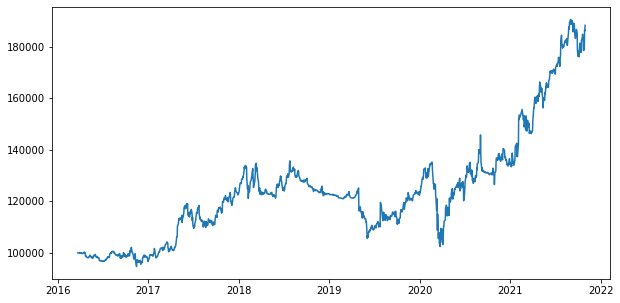

In [12]:
if __name__ == '__main__':

    test1()
    for i in range(nb_of_rows):

        date=data.index[i]
        high=data.iloc[i, 1]
        low = data.iloc[i, 2]
        closep = data.iloc[i, 3]
        openp = data.iloc[i, 0]
        volume = data.iloc[i, 5]
        price=data.iloc[i, 4]
        SP500=data.iloc[i,-1]

        price_information={'date' : date,
                           'price' : float(price),
                           'high' : float(high),
                           'low': float(low),
                           'close' : float(closep),
                           'open' : float(openp),
                           'volume' : float(volume),
                           'SP500' : float(SP500)}
        action = naive_backtester.onMarketDataReceived(price_information)
        naive_backtester.buy_sell_or_hold_something(price_information,action)

    print("PNL:%.2f" % (naive_backtester.list_total[-1] - 10000 ))
    #print(naive_backtester.trade_date_list)
    
    #PNL
    log_x = naive_backtester.list_date[500:]
    log_y = naive_backtester.list_total[501:]
    plt.figure(figsize=(10, 5))
    plt.plot(log_x, log_y)
    #print(naive_backtester.list_trade)
    
    #risk
    log_sharpe_ratio=(numpy.mean(naive_backtester.list_return[500:])-1.923/100/252)/numpy.std(naive_backtester.list_return[500:])
    log_annual_sharpe_ratio = log_sharpe_ratio*numpy.sqrt(252)
    print("Sharpe ratio: ", log_annual_sharpe_ratio)
    
    #decay
    log_trade_date=naive_backtester.trade_date_list  
    log_trade=naive_backtester.list_trade



Next, run with the suppoer vector machine strategy

PNL:212542.21
Sharpe ratio:  0.8115960715114415


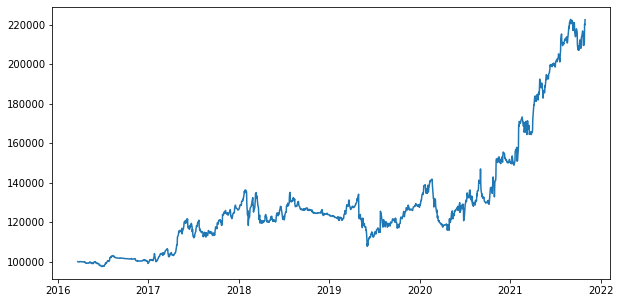

In [13]:
if __name__ == '__main__':

    test2()
    for i in range(nb_of_rows):

        date=data.index[i]
        high=data.iloc[i, 1]
        low = data.iloc[i, 2]
        closep = data.iloc[i, 3]
        openp = data.iloc[i, 0]
        volume = data.iloc[i, 5]
        price=data.iloc[i, 4]
        SP500=data.iloc[i, -1]

        price_information={'date' : date,
                           'price' : float(price),
                           'high' : float(high),
                           'low': float(low),
                           'close' : float(closep),
                           'open' : float(openp),
                           'volume' : float(volume),
                           'SP500':float(SP500)}
        action = naive_backtester.onMarketDataReceived(price_information)
        naive_backtester.buy_sell_or_hold_something(price_information,action)



    print("PNL:%.2f" % (naive_backtester.list_total[-1] - 10000 ))
    #print(naive_backtester.trade_date_list)
    
    #PNL
    svm_x = naive_backtester.list_date[500:]
    svm_y = naive_backtester.list_total[501:]
    plt.figure(figsize=(10, 5))
    plt.plot(svm_x, svm_y)
    #print(naive_backtester.list_trade)
    
    #risk
    svm_sharpe_ratio=(numpy.mean(naive_backtester.list_return[500:])-1.923/100/252)/numpy.std(naive_backtester.list_return[500:])
    svm_annual_sharpe_ratio = svm_sharpe_ratio*numpy.sqrt(252)
    print("Sharpe ratio: ", svm_annual_sharpe_ratio)
    
    #decay
    svm_trade_date=naive_backtester.trade_date_list  
    svm_trade=naive_backtester.list_trade
    
    

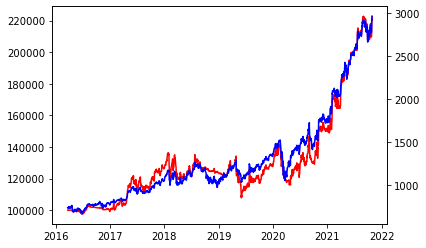

In [14]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(svm_x, svm_y,'r',label='svm')
ax2 = ax.twinx()
ax2.plot(data['Adj Close'][500:],'b',label='stock')

Then, run with the random forest strategy

PNL:132799.78
Sharpe ratio:  0.3857375243932902


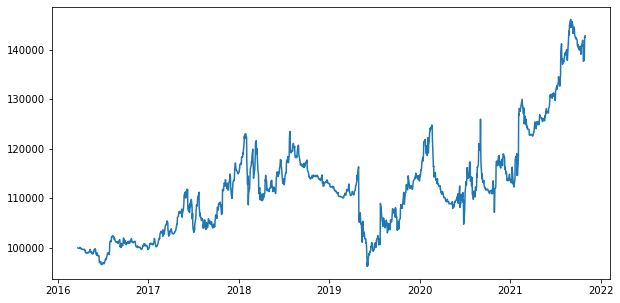

In [15]:
if __name__ == '__main__':

    test3()
    for i in range(nb_of_rows):

        date=data.index[i]
        high=data.iloc[i, 1]
        low = data.iloc[i, 2]
        closep = data.iloc[i, 3]
        openp = data.iloc[i, 0]
        volume = data.iloc[i, 5]
        price=data.iloc[i, 4]
        SP500=data.iloc[i, -1]

        price_information={'date' : date,
                           'price' : float(price),
                           'high' : float(high),
                           'low': float(low),
                           'close' : float(closep),
                           'open' : float(openp),
                           'volume' : float(volume),
                           'SP500' : float(SP500)}
        action = naive_backtester.onMarketDataReceived(price_information)
        naive_backtester.buy_sell_or_hold_something(price_information,action)
        #print(naive_backtester.trade_date_list)



    print("PNL:%.2f" % (naive_backtester.list_total[-1] - 10000 ))
    
    #PNL
    rf_x = naive_backtester.list_date[500:]
    rf_y = naive_backtester.list_total[501:]
    plt.figure(figsize=(10, 5))
    plt.plot(rf_x, rf_y)
    #print(naive_backtester.list_trade)
    
    #risk
    rf_sharpe_ratio=(numpy.mean(naive_backtester.list_return[500:])-1.923/100/252)/numpy.std(naive_backtester.list_return[500:])
    rf_annual_sharpe_ratio = rf_sharpe_ratio*numpy.sqrt(252)
    print("Sharpe ratio: ", rf_annual_sharpe_ratio)
    
    #decay
    rf_trade_date=naive_backtester.trade_date_list  
    rf_trade=naive_backtester.list_trade
   
    

Finally, run with the random walk (naive) strategy for comparison

PNL:158129.51
Sharpe ratio:  0.5384796878939399


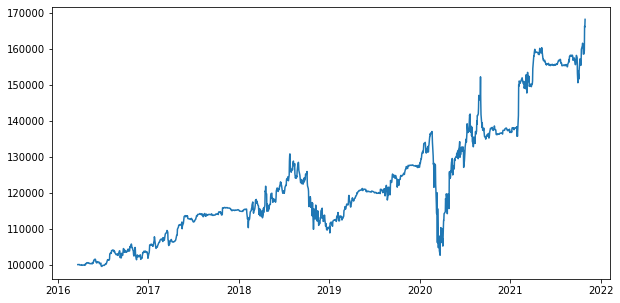

In [16]:
if __name__ == '__main__':

    test4()
    for i in range(nb_of_rows):

        date=data.index[i]
        high=data.iloc[i, 1]
        low = data.iloc[i, 2]
        closep = data.iloc[i, 3]
        openp = data.iloc[i, 0]
        volume = data.iloc[i, 5]
        price=data.iloc[i, 4]
        SP500=data.iloc[i, -1]

        price_information={'date' : date,
                           'price' : float(price),
                           'high' : float(high),
                           'low': float(low),
                           'close' : float(closep),
                           'open' : float(openp),
                           'volume' : float(volume),
                           'SP500' : float(SP500)}
        action = naive_backtester.onMarketDataReceived(price_information)
        naive_backtester.buy_sell_or_hold_something(price_information,action)



    print("PNL:%.2f" % (naive_backtester.list_total[-1] - 10000 ))

    #PNL
    naive_x = naive_backtester.list_date[500:]
    naive_y = naive_backtester.list_total[501:]
    plt.figure(figsize=(10, 5))
    plt.plot(naive_x, naive_y)
    #print(naive_backtester.list_trade)
    
    #risk
    naive_sharpe_ratio=(numpy.mean(naive_backtester.list_return[500:])-1.923/100/252)/numpy.std(naive_backtester.list_return[500:])
    naive_annual_sharpe_ratio = naive_sharpe_ratio*numpy.sqrt(252)
    print("Sharpe ratio: ", naive_annual_sharpe_ratio)
    
    #decay
    naive_trade_date=naive_backtester.trade_date_list  
    naive_trade=naive_backtester.list_trade
    

The following are the analysis on PNL, risk, and decay that serve to compare different trading strategies.

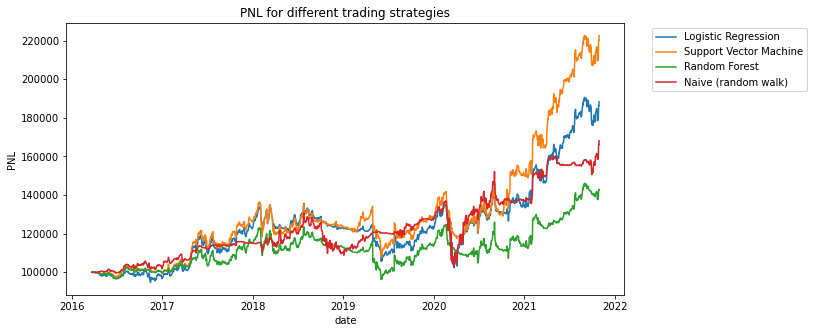

In [17]:
#PNL for different trading strategies
plt.figure(figsize=(10, 5))
plt.plot(log_x, log_y, label = "Logistic Regression")
plt.plot(svm_x, svm_y, label = "Support Vector Machine")
plt.plot(rf_x, rf_y, label = "Random Forest")
plt.plot(naive_x,naive_y,label="Naive (random walk)")
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
plt.title("PNL for different trading strategies")
plt.xlabel("date")
plt.ylabel("PNL")
plt.show()

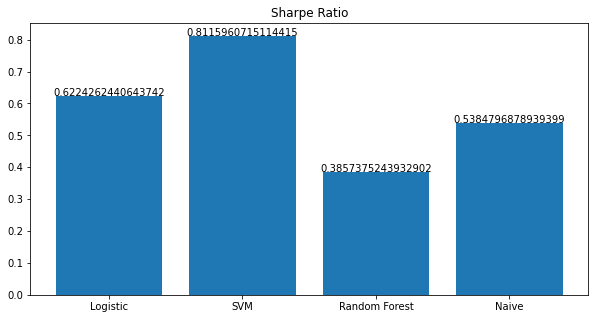

In [18]:
#Risk - Sharpe Ratio, the higher the better
x = ['Logistic', 'SVM', 'Random Forest', 'Naive']
y = [log_annual_sharpe_ratio, svm_annual_sharpe_ratio,rf_annual_sharpe_ratio,naive_annual_sharpe_ratio]
plt.figure(figsize=(10, 5))
plt.bar(x, y)
plt.title("Sharpe Ratio")
for i in range(len(x)):
    plt.text(i, y[i], y[i], ha = 'center')
plt.show()

In [19]:
#function to plot decay
def decay_mean(trade_date,trade,n):
    decay=pandas.DataFrame(data=range(n))
    a=[]
    position=trade[0]
    for i in range(len(trade_date)):
        #if (i)%n==0:    
            date=trade_date[i]
            begin=data.loc[date, "Adj Close"]
            a.extend(data.loc[date:, "Adj Close"][:n]*position)
            a=numpy.array(a)-begin*position
            if len(a)<n:
                break
            decay[date]=numpy.array(a)
            a=[]
            position=trade[i]
    decay= decay.reset_index()
    decay_mean=decay.mean(1)
    #print(decay)
    #print(decay_mean)
    plt.figure()
    decay_mean.plot(legend=None)

In [20]:
def decay(trade_date,trade,n):
    decay=pandas.DataFrame(data=range(n))
    a=[]
    position=trade[0]
    for i in range(len(trade_date)):
        #if (i)%n==0:    
            date=trade_date[i]
            begin=data.loc[date, "Adj Close"]
            a.extend(data.loc[date:, "Adj Close"][:n]*position)
            a=numpy.array(a)-begin*position
            if len(a)<n:
                break
            decay[date]=numpy.array(a)
            a=[]
            position=trade[i]
    decay= decay.reset_index()
    #decay_mean=decay.mean(1)
    #print(decay)
    #print(decay_mean)
    #decay.plot(legend=None)
    plt.figure()
    decay.plot(legend=None)

/var/folders/v1/8y4p5y8x15z3cnbw9hxsxb8h0000gn/T/ipykernel_10107/379821317.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  decay[date]=numpy.array(a)
/var/folders/v1/8y4p5y8x15z3cnbw9hxsxb8h0000gn/T/ipykernel_10107/379821317.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  decay[date]=numpy.array(a)
/var/folders/v1/8y4p5y8x15z3cnbw9hxsxb8h0000gn/T/ipykernel_10107/379821317.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

Text(0.5, 1.0, 'navie_decay')

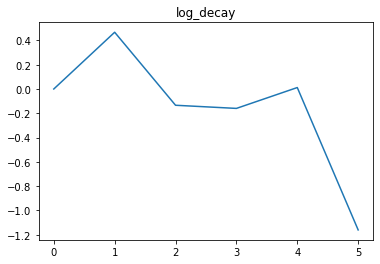

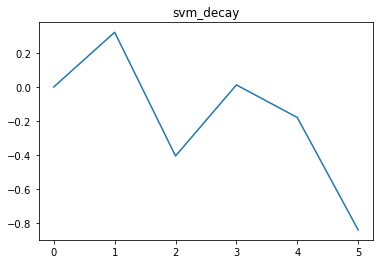

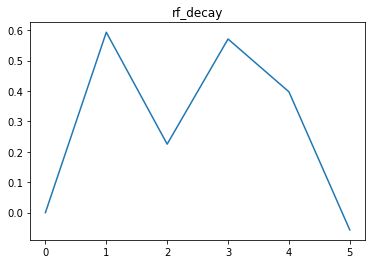

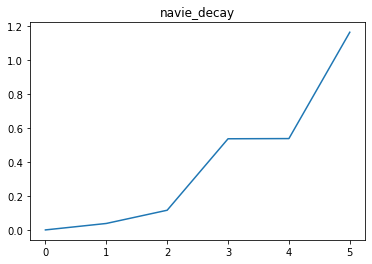

In [21]:
#decay
decay_mean(log_trade_date,log_trade, 6)
plt.title("log_decay")
decay_mean(svm_trade_date,svm_trade, 6)
plt.title("svm_decay")
decay_mean(rf_trade_date,rf_trade, 6)
plt.title("rf_decay")
decay_mean(naive_trade_date,naive_trade, 6)
plt.title("naive_decay")

/var/folders/v1/8y4p5y8x15z3cnbw9hxsxb8h0000gn/T/ipykernel_10107/1215734007.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  decay[date]=numpy.array(a)
/var/folders/v1/8y4p5y8x15z3cnbw9hxsxb8h0000gn/T/ipykernel_10107/1215734007.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  decay[date]=numpy.array(a)
/var/folders/v1/8y4p5y8x15z3cnbw9hxsxb8h0000gn/T/ipykernel_10107/1215734007.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perf

Text(0.5, 1.0, 'navie_decay')

<Figure size 432x288 with 0 Axes>

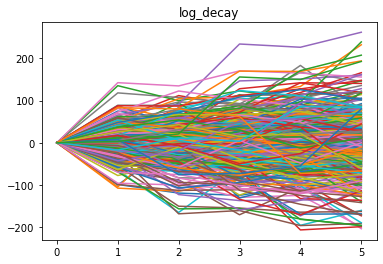

<Figure size 432x288 with 0 Axes>

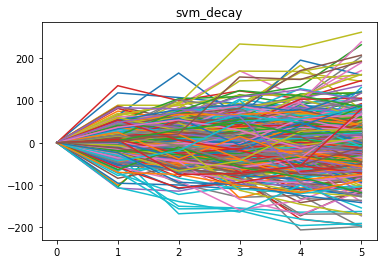

<Figure size 432x288 with 0 Axes>

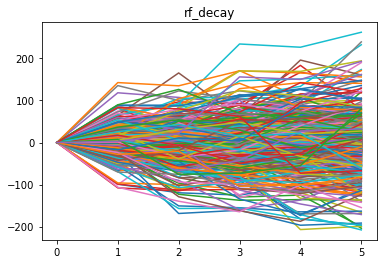

<Figure size 432x288 with 0 Axes>

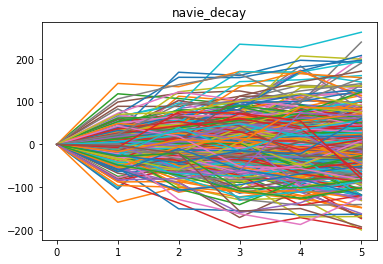

In [22]:
decay(log_trade_date,log_trade, 6)
plt.title("log_decay")
decay(svm_trade_date,svm_trade, 6)
plt.title("svm_decay")
decay(rf_trade_date,rf_trade, 6)
plt.title("rf_decay")
decay(naive_trade_date,naive_trade, 6)
plt.title("naive_decay")